# 🎯 DCA Polymarket Backtesting

Clean notebook for backtesting DCA momentum strategy.

## Sections:
1. **Setup & Data Loading**
2. **Core Functions**
3. **Manual Backtest**
4. **Visualization**
5. **Debug Export**
6. **Optuna Optimization**

---
## 1. Setup & Data Loading

In [19]:
# Install dependencies
!pip3 install optuna openpyxl pyarrow matplotlib -q

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ibapi-10.19.4-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [20]:
# Imports
import pandas as pd
import numpy as np
import json
import warnings
import optuna
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Border, Side, Alignment
from openpyxl.utils import get_column_letter

warnings.filterwarnings('ignore')
print("✅ Imports complete")

✅ Imports complete


In [18]:
# ============================================
# LOAD DATA
# ============================================
# Change this path to your parquet file

DATA_PATH = 'snapshots_26jan.parquet'  # <- CHANGE THIS

df = pd.read_parquet(DATA_PATH)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

print(f"Loaded {len(df):,} rows")
print(f"Columns: {list(df.columns)}")
print(f"Time range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Markets: {df['market_id'].nunique()}")
df.head()

Loaded 2,060,124 rows
Columns: ['timestamp', 'datetime', 'asset_id', 'market_id', 'mid_price', 'best_bid', 'best_ask', 'spread', 'raw_json']
Time range: 2026-01-26 20:18:29.891000 to 2026-01-27 06:50:48.137000
Markets: 6


,timestamp,datetime,asset_id,market_id,mid_price,best_bid,best_ask,spread,raw_json
0,1769458709891,2026-01-26 20:18:29.891,1937078631337534994422259351205966953596448752...,0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490...,0.61,0.60,0.62,0.02,"{""asset_id"": ""19370786313375349944222593512059..."
1,1769458709891,2026-01-26 20:18:29.891,1909996176002823310211903148409652101392504119...,0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490...,0.39,0.38,0.40,0.02,"{""asset_id"": ""19099961760028233102119031484096..."
2,1769458709921,2026-01-26 20:18:29.921,1937078631337534994422259351205966953596448752...,0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490...,0.61,0.60,0.62,0.02,"{""asset_id"": ""19370786313375349944222593512059..."
3,1769458709921,2026-01-26 20:18:29.921,1909996176002823310211903148409652101392504119...,0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490...,0.39,0.38,0.40,0.02,"{""asset_id"": ""19099961760028233102119031484096..."
4,1769458709976,2026-01-26 20:18:29.976,1937078631337534994422259351205966953596448752...,0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490...,0.61,0.60,0.62,0.02,"{""asset_id"": ""19370786313375349944222593512059..."


In [21]:
# ============================================
# KNOWN WINNERS - DEFINE YOUR WINNERS HERE
# ============================================
# Map market_id -> winning asset_id
# Get market/asset IDs by running: list_markets(df)
known_winners_25jan = {
    '0x0ad7bfefa1318072a7718199b97c81e3815c013987400910ec4f341eab657163': '22548266195851269689477719506198642269528767995990837775232261605151563451942', #warrios
    '0x548bf24ac69dda721ac2c9f70ddf7d4907ddebfaa552b3c9d90c2ea579759850': '51674227959772201692995587953323756294034141098159045110117222361966129767794', #pelicans
    '0x3b55b213f4d41ecf371a0308ea5e9bac95667b048828593908c5d6011f53c46f': '85996455898810555143401747386030485146842361772986418197315925327109740729086', #lakers
    # POSTPONED'0xf440e62234f2ee9be68a6ef7cad4bbf8a0aa8591ca7393061bca614651dd7165': '103069867371701144274707916726602160059633490990003222285779377518286262505715', #heat
    '0xc71b8b2579a7b51d49cfda84312ae613ab5fca893659a0cc5d83116cdc689b35': '42126278325805086214134314057239966182355296066644260428412036278357258960610', #heat
    '0x87d597755d0b8cb400ef7f1b2437a6ea5f84d25002951b676a1b783b26dad578': '17666858862007195233465506261917218863242430381450028132230016398149405665134' #clippers

}


known_winners_24jan = {
    '0x88cb460d5214d9ef799a9a74941d2899fe15d427b15cbb24140328514b72ffab': '42781397119150928524620980569712935893636283323356676294919480802104602608040', #bulls
    '0xd32bca26a2e0691b235c19a79a7ab1893289be98e987a811cfadc9d927df9ccd': '91882959557077986206360079185370037618383834179859904199045807600717043152693', #cavaliers
    #minnesota postponed
    '0x6698f3324b7f643dfa2c9bcd2ecefa65935714b505eb5ee4ae15c139e48a3ea3': '13882206331450371303568000116534203832428526824407877756346123225263754654563', #lakers
    '0x188710cca5d961454b0173c03be5643b32bacb9a5cc1df7cccd5eb0958308808': '103069867371701144274707916726602160059633490990003222285779377518286262505715', #heat
    '0xac2f84f4fd9252fd9d65badfcc30b5854018ab848c52ed220b108bf0c01a59e4': '100839774769010266331661617202208847432106473005501947665369602880398232703155' #knicks

}


known_winners_26jan = {
    '0xfa2de983f8642c0f61c6c9f6890144c00569720c7ac4966fa14ae61887805119': '100867343898929430052757546050745655715685585456696690891892865600379098158025', #timberwolves
    '0x31ab55ffa13f6db8e57d399ea90d4efa108e4ea3ebe8254b8dd711ce0300a44b': '87800006559503182362481555183568667613755424315939426292124794493674893045177', #lakers
    '0x0ec8aba4da6ff2d822375826e5b26a77ad44475880806e3911208676c8b27189': '50360611238162519349597526846658115119614668036291381303699223838097185992619', #rockets
    '0x1fc322c68723e7d66ccf795cdb8cf229ddb02e0e44b7d92e4d7818a6a8effab1': '12538008096049809260959942696355073549474960063955610419251367912602775702371', #cavaliers
    '0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490859114f2a544d295f9e1': '19370786313375349944222593512059669535964487521741074120538382195117540825433', #hornets
    '0x09aa5f4210ff3e17e65072e73bf084a1d72246ec712b8d33c4efbc958192a435': '112460056466301987895624067988030855175451380171501724318327858610989988015996' #celtics
}


known_winners_27jan = {
    '0xdc61b928589ea4d3e97bbb80a27e84eca4f59cfa9c37319ba2a7b63199bcdf31': '114810619020440066196286636298926087160454506616717843900975576221717806376761', #arkansas
    '0xa338b21f43ccf35f427c9674a0effde074d28cabb7e2358ec498a1ba049b9470': '105917824473601761478847321769933632598106021887333748710627510244193706793258', #ucf knights
    '0xfbbca64429c68fe60f8b7f5713cb7c2b6e3f0b72ad72ead6e30c7bd7f03d2328': '114403476857604701724608088874049221045243705059599768206726165533185920136385', #houston christian
    '0x96efea44484d3752fa72dc3ca5987c2e16a006112dbbe0174730b8ad5932c98f': '518272430027893766986552798258835853433678957912568820764900306532617260527', #mcneese
    '0xb358099a4d3cd1908fafa4ef492d131a4d30a41866b556ac65ea0db905ec78a1': '48924055834814888428606569679658798321783136070365706735814433351016547108906', #VCU
    '0x6cefa261bfbee131da94a3ca013886a58606ae27055175ee62910251cd9aa532': '81640735300133043464899322835663435037559272815252333754895208703479291308029', #nca state
    '0x4e99e7565b30f92229489999e659a3136632449d88fc011bd4e8cc06c484ccca': '87890321414384780337490094423156067406932290358906185528607515117644478595310', #virginia
    '0x538be58810bd07707c1e849da9b4de12dc6617739c2e87043ea9b7fb2b6266c3': '41247652063966004401306857419416685235874842651432515489339067969075836389387', #suns
    '0xcbed61cd2f96e0137ad098dcd8941efedea6f2e304f8b786f2a177ffffa9328a': '27061289282536287632793183240411687357181345607670439418333463229431698897460', #pistons
    '0x42c36cff27c928a58f71626244fb1acebcfd963976972cc03dc46c809a8663da': '41882622457175161594434643470609594422739676193078727425608733682888208989127', #clippers
    '0xbf399bc9894b502586ad0ed7383fffcadb07c21c507fb2a84a991741763a8efc': '35923522612276750394651557626496020946647566899591212994355411047671496757110', #76ers
    '0xf6a808c701b3432667fc8f21b3fe05259264cb45276aa7fcd2a7d486bfaa3601': '88289804616935923809321119252865056808373694473082600665834909738008415308474', #thunderr
    '0xa9c0c820fd79b4339ed4711288ce15236196a6015234350f42b37341e9094398': '91609514063242777856043730063938310894548353925882406409927495687846407164056', #wizards
    '0xf42921f761a9553b33c3bcfebc42f48218b9147cf33d137f8daf28da996d5642': '72061868768744363794309804812683635190849437054114408108529113134643926789227', #knicks



}
print("✅ Known winners defined")

✅ Known winners defined


In [22]:
# ============================================
# LOAD MULTIPLE DAYS (for Optuna)
# ============================================
# Uncomment and modify paths as needed

# df_24jan = pd.read_parquet('snapshots_24jan.parquet')
# df_24jan['datetime'] = pd.to_datetime(df_24jan['datetime'])

# df_25jan = pd.read_parquet('snapshots_25jan.parquet')
# df_25jan['datetime'] = pd.to_datetime(df_25jan['datetime'])

# df_26jan = pd.read_parquet('snapshots_26jan.parquet')
# df_26jan['datetime'] = pd.to_datetime(df_26jan['datetime'])

# print("✅ Multiple days loaded")

---
## 2. Core Functions

In [23]:
# ============================================
# ORDERBOOK FUNCTIONS
# ============================================

def parse_orderbook(raw_json):
    if not raw_json or pd.isna(raw_json) or not isinstance(raw_json, str):
        return None
    try:
        clean = raw_json.strip()
        if clean.startswith('"'): clean = clean[1:]
        if clean.endswith('"'): clean = clean[:-1]
        clean = clean.replace('""', '"')
        data = json.loads(clean)
        bids = sorted([{'price': float(b['price']), 'size': float(b['size'])} for b in data.get('bids', [])], key=lambda x: x['price'], reverse=True)
        asks = sorted([{'price': float(a['price']), 'size': float(a['size'])} for a in data.get('asks', [])], key=lambda x: x['price'])
        return {'bids': bids, 'asks': asks, 'best_bid': bids[0]['price'] if bids else None, 'best_ask': asks[0]['price'] if asks else None}
    except:
        return None

def execute_buy_from_orderbook(asks, amount_usd):
    if not asks or amount_usd <= 0:
        return 0, 0, 0, []
    shares_filled, total_cost, remaining_usd, fills = 0, 0, amount_usd, []
    for ask in asks:
        if remaining_usd <= 0: break
        price, available_size = ask['price'], ask['size']
        shares_at_level = min(available_size, remaining_usd / price)
        cost_at_level = shares_at_level * price
        shares_filled += shares_at_level
        total_cost += cost_at_level
        remaining_usd -= cost_at_level
        fills.append({'price': price, 'size': shares_at_level, 'cost': cost_at_level})
    return shares_filled, total_cost, (total_cost / shares_filled if shares_filled > 0 else 0), fills

def execute_sell_into_orderbook(bids, shares_to_sell):
    if not bids or shares_to_sell <= 0:
        return 0, 0, 0, [], shares_to_sell
    shares_sold, total_proceeds, remaining_shares, fills = 0, 0, shares_to_sell, []
    for bid in bids:
        if remaining_shares <= 0: break
        price, available_size = bid['price'], bid['size']
        shares_at_level = min(available_size, remaining_shares)
        proceeds_at_level = shares_at_level * price
        shares_sold += shares_at_level
        total_proceeds += proceeds_at_level
        remaining_shares -= shares_at_level
        fills.append({'price': price, 'size': shares_at_level, 'proceeds': proceeds_at_level})
    return shares_sold, total_proceeds, (total_proceeds / shares_sold if shares_sold > 0 else 0), fills, remaining_shares

print("✅ Orderbook functions loaded")

✅ Orderbook functions loaded


In [24]:
# ============================================
# BACKTEST V6 ENGINE
# ============================================

def run_backtest_v6(params, df_resampled, market_winners, initial_capital=500, global_tp_pct=0.07):
    ENTRY_THRESHOLD = params['entry_threshold']
    EXIT_STOP_LOSS = params['exit_stop_loss']
    STOP_LOSS_PCT = params['stop_loss_pct']
    TAKE_PROFIT_PCT = params['take_profit_pct']
    COOLDOWN_PERIODS = params.get('cooldown_periods', 10)
    GLOBAL_TP_TARGET = initial_capital * global_tp_pct

    DCA_TIERS = [
        ('entry', ENTRY_THRESHOLD, params['weight_entry']),
        ('tier_1', params['dca_tier_1'], params['weight_tier_1']),
        ('tier_2', params['dca_tier_2'], params['weight_tier_2']),
        ('tier_3', params['dca_tier_3'], params['weight_tier_3']),
    ]

    markets = df_resampled['market_id'].unique()
    num_markets = len(markets)
    capital_per_market = initial_capital / num_markets

    market_state = {
        market: {
            'allocation': capital_per_market, 'cash': capital_per_market, 'positions': {},
            'active_asset': None, 'tiers_invested': set(), 'pnl': 0, 'trades': [],
            'cooldown_until': {}, 'stop_loss_count': 0, 'take_profit_count': 0,
        } for market in markets
    }

    total_wins, total_losses, all_trades = 0, 0, []
    df_sorted = df_resampled.sort_values('datetime')
    global_tp_triggered, global_tp_timestamp = False, None
    price_cache = {}

    for _, row in df_sorted.iterrows():
        if global_tp_triggered: continue
        asset_id, market_id, mid_price = row['asset_id'], row['market_id'], row['mid_price']
        timestamp, raw_json = row['datetime'], row.get('raw_json', None)
        if pd.isna(mid_price): continue

        state = market_state[market_id]
        orderbook = parse_orderbook(raw_json)
        best_bid = orderbook.get('best_bid', mid_price) if orderbook else mid_price
        best_ask = orderbook.get('best_ask', mid_price) if orderbook else mid_price
        price_cache[(market_id, asset_id)] = mid_price
        has_position = asset_id in state['positions'] and state['positions'][asset_id]['shares'] > 0

        # Global TP check
        total_realized = sum(s['pnl'] for s in market_state.values())
        total_unrealized = sum((price_cache.get((m, a), 0) * p['shares']) - p['cost_basis'] 
                              for m, s in market_state.items() for a, p in s['positions'].items() if p['shares'] > 0)
        if total_realized + total_unrealized >= GLOBAL_TP_TARGET:
            global_tp_triggered, global_tp_timestamp = True, timestamp
            for mkt_id, mkt_state in market_state.items():
                for ast_id, pos in list(mkt_state['positions'].items()):
                    if pos['shares'] > 0:
                        curr_price = price_cache.get((mkt_id, ast_id), 0)
                        if curr_price <= 0: continue
                        proceeds = pos['shares'] * curr_price
                        pnl = proceeds - pos['cost_basis']
                        mkt_state['trades'].append({'timestamp': timestamp, 'market_id': mkt_id, 'asset_id': ast_id, 'action': 'SELL', 'reason': 'GLOBAL_TP', 'pnl': pnl})
                        all_trades.append({'timestamp': timestamp, 'action': 'SELL', 'reason': 'GLOBAL_TP', 'pnl': pnl})
                        mkt_state['pnl'] += pnl
                        mkt_state['cash'] += proceeds
                        if pnl > 0: total_wins += 1
                        else: total_losses += 1
                        pos['shares'], pos['cost_basis'] = 0, 0
            break

        # Exit logic
        if has_position:
            pos = state['positions'][asset_id]
            avg_entry = pos['cost_basis'] / pos['shares'] if pos['shares'] > 0 else 0
            should_exit, exit_reason = False, ''
            if best_bid and best_bid < EXIT_STOP_LOSS:
                should_exit, exit_reason = True, 'STOP_LOSS_ABS'
            elif avg_entry > 0 and best_bid and best_bid < avg_entry * (1 - STOP_LOSS_PCT):
                should_exit, exit_reason = True, 'STOP_LOSS_PCT'
            elif avg_entry > 0 and best_bid and best_bid >= avg_entry * (1 + TAKE_PROFIT_PCT):
                should_exit, exit_reason = True, 'TAKE_PROFIT'
            
            if should_exit:
                if orderbook and orderbook.get('bids'):
                    shares_sold, proceeds, avg_exit, fills, unfilled = execute_sell_into_orderbook(orderbook['bids'], pos['shares'])
                else:
                    shares_sold, proceeds = pos['shares'], pos['shares'] * best_bid
                pnl = proceeds - pos['cost_basis']
                state['trades'].append({'timestamp': timestamp, 'action': 'SELL', 'reason': exit_reason, 'pnl': pnl})
                all_trades.append({'timestamp': timestamp, 'action': 'SELL', 'reason': exit_reason, 'pnl': pnl})
                state['pnl'] += pnl
                state['cash'] += proceeds
                if pnl > 0: total_wins += 1
                else: total_losses += 1
                state['positions'][asset_id] = {'shares': 0, 'cost_basis': 0}
                state['active_asset'], state['tiers_invested'] = None, set()
                state['cooldown_until'][asset_id] = timestamp + pd.Timedelta(seconds=30 * COOLDOWN_PERIODS)
                if 'STOP_LOSS' in exit_reason: state['stop_loss_count'] += 1
                else: state['take_profit_count'] += 1
                continue

        # Cooldown check
        if asset_id in state['cooldown_until']:
            if timestamp < state['cooldown_until'][asset_id]: continue
            else: del state['cooldown_until'][asset_id]

        # Entry / DCA
        if mid_price >= ENTRY_THRESHOLD:
            if state['active_asset'] is None: state['active_asset'] = asset_id
            if state['active_asset'] == asset_id:
                for tier_name, threshold, weight in DCA_TIERS:
                    if tier_name in state['tiers_invested']: continue
                    if mid_price >= threshold:
                        invest_amount = min(state['allocation'] * weight, state['cash'])
                        if invest_amount > 1 and orderbook and orderbook.get('asks'):
                            shares, cost, avg_price, fills = execute_buy_from_orderbook(orderbook['asks'], invest_amount)
                            if shares > 0:
                                if asset_id not in state['positions']: state['positions'][asset_id] = {'shares': 0, 'cost_basis': 0}
                                state['positions'][asset_id]['shares'] += shares
                                state['positions'][asset_id]['cost_basis'] += cost
                                state['cash'] -= cost
                                state['tiers_invested'].add(tier_name)
                                state['trades'].append({'timestamp': timestamp, 'action': 'BUY', 'reason': tier_name, 'cost': cost})
                                all_trades.append({'timestamp': timestamp, 'action': 'BUY', 'reason': tier_name, 'cost': cost})

        # Asset switch
        if state['active_asset'] and state['active_asset'] != asset_id:
            if state['positions'].get(state['active_asset'], {}).get('shares', 0) == 0:
                if asset_id not in state['cooldown_until'] and mid_price >= ENTRY_THRESHOLD:
                    state['active_asset'], state['tiers_invested'] = asset_id, set()

    # Force close at end
    if not global_tp_triggered:
        for market_id, state in market_state.items():
            winner_info = market_winners.get(market_id)
            if not winner_info: continue
            for asset_id, pos in state['positions'].items():
                if pos['shares'] > 0:
                    close_price = winner_info['winner_price'] if asset_id == winner_info['winner_asset'] else winner_info['loser_price']
                    proceeds = pos['shares'] * close_price
                    pnl = proceeds - pos['cost_basis']
                    state['pnl'] += pnl
                    state['cash'] += proceeds
                    if pnl > 0: total_wins += 1
                    else: total_losses += 1
                    all_trades.append({'action': 'SELL', 'reason': 'MARKET_CLOSE', 'pnl': pnl})

    final_value = sum(s['cash'] for s in market_state.values())
    return {
        'total_return': (final_value - initial_capital) / initial_capital,
        'total_pnl': sum(s['pnl'] for s in market_state.values()),
        'final_value': final_value, 'wins': total_wins, 'losses': total_losses,
        'win_rate': total_wins / (total_wins + total_losses) if (total_wins + total_losses) > 0 else 0,
        'stop_loss_count': sum(s['stop_loss_count'] for s in market_state.values()),
        'take_profit_count': sum(s['take_profit_count'] for s in market_state.values()),
        'global_tp_triggered': global_tp_triggered, 'global_tp_timestamp': global_tp_timestamp,
        'trades': pd.DataFrame(all_trades), 'market_state': market_state
    }

print("✅ Backtest V6 engine loaded")


✅ Backtest V6 engine loaded


In [25]:
# ============================================
# RUN SINGLE BACKTEST
# ============================================

def run_single_backtest(df_data, params=None, initial_capital=500, verbose=True, known_winners=None, global_tp_pct=0.07, selected_markets=None):
    default_params = {
        'entry_threshold': 0.68, 'exit_stop_loss': 0.50, 'stop_loss_pct': 0.15, 'take_profit_pct': 0.20,
        'cooldown_periods': 10, 'dca_tier_1': 0.75, 'dca_tier_2': 0.85, 'dca_tier_3': 0.92,
        'weight_entry': 0.15, 'weight_tier_1': 0.20, 'weight_tier_2': 0.30, 'weight_tier_3': 0.35,
    }
    if params is None: params = default_params
    else:
        for k, v in default_params.items():
            if k not in params: params[k] = v

    total_w = params['weight_entry'] + params['weight_tier_1'] + params['weight_tier_2'] + params['weight_tier_3']
    for k in ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3']:
        params[k] /= total_w

    df_backtest = df_data.copy()
    if 'datetime' not in df_backtest.columns and df_backtest.index.name == 'datetime':
        df_backtest = df_backtest.reset_index()
    df_backtest = df_backtest.sort_values('datetime')

    # Market selection
    all_markets = df_backtest['market_id'].unique()
    if selected_markets is not None:
        selected_ids = [all_markets[m] if isinstance(m, int) and m < len(all_markets) else m for m in selected_markets]
        selected_ids = [m for m in selected_ids if m in all_markets]
        df_backtest = df_backtest[df_backtest['market_id'].isin(selected_ids)]
        if verbose: print(f"📊 Selected {len(selected_ids)} of {len(all_markets)} markets")

    # Resample
    if 'raw_json' in df_backtest.columns:
        df_indexed = df_backtest.set_index('datetime')
        def last_valid(x):
            valid = x.dropna()
            return valid.iloc[-1] if len(valid) > 0 else None
        df_resampled = df_indexed.groupby(['asset_id', 'market_id']).resample('5s').agg({'mid_price': 'last', 'raw_json': last_valid}).reset_index()
        df_resampled = df_resampled.dropna(subset=['mid_price'])
    else:
        df_resampled = df_backtest
    df_resampled = df_resampled.sort_values(['asset_id', 'datetime'])

    # Build market winners
    markets = df_resampled['market_id'].unique()
    market_winners = {}
    for market in markets:
        market_data = df_resampled[df_resampled['market_id'] == market]
        last_ts = market_data['datetime'].max()
        last_prices = market_data[market_data['datetime'] == last_ts][['asset_id', 'mid_price']].dropna().copy()
        if len(last_prices) == 0: continue
        
        if known_winners and market in known_winners:
            market_winners[market] = {'winner_asset': known_winners[market], 'winner_price': 1.0, 'loser_price': 0.0, 'last_ts': last_ts}
        else:
            last_prices['dist'] = abs(1.0 - last_prices['mid_price'])
            winner_idx = last_prices['dist'].idxmin()
            loser_prices = last_prices[last_prices.index != winner_idx]
            market_winners[market] = {
                'winner_asset': last_prices.loc[winner_idx, 'asset_id'],
                'winner_price': last_prices.loc[winner_idx, 'mid_price'],
                'loser_price': loser_prices['mid_price'].iloc[0] if len(loser_prices) > 0 else 0,
                'last_ts': last_ts
            }

    results = run_backtest_v6(params, df_resampled, market_winners, initial_capital, global_tp_pct)
    results['params'], results['market_winners'] = params, market_winners

    if verbose:
        print("\n" + "="*50)
        print("💰 BACKTEST RESULTS")
        print("="*50)
        print(f"Capital: ${initial_capital:.2f} → ${results['final_value']:.2f} ({results['total_return']*100:.1f}%)")
        print(f"P&L: ${results['total_pnl']:.2f} | Win Rate: {results['win_rate']*100:.0f}%")
        print(f"Wins: {results['wins']} | Losses: {results['losses']}")
        if results['global_tp_triggered']:
            print(f"🎯 Global TP triggered at {results['global_tp_timestamp']}")
        print("\n📋 Per Market:")
        for i, (mid, st) in enumerate(results['market_state'].items()):
            print(f"  Market {i+1}: ${st['pnl']:+.2f}")
    
    return results

def list_markets(df):
    markets = df['market_id'].unique()
    print(f"\n📋 {len(markets)} Markets:")
    for i, mid in enumerate(markets):
        mdf = df[df['market_id'] == mid]
        print(f"  {i}: {mid[:40]}... ({len(mdf):,} rows)")
    print("\n💡 Usage: run_single_backtest(df, selected_markets=[0, 2])")

print("✅ Single backtest loaded")
print("   list_markets(df)")
print("   run_single_backtest(df, selected_markets=[0])")


✅ Single backtest loaded
   list_markets(df)
   run_single_backtest(df, selected_markets=[0])


---
## 3. Manual Backtest


In [26]:
# List markets
list_markets(df)



📋 6 Markets:
  0: 0xfdc2ca60f0240b3d309dc2aa8fc80b30121003... (182,150 rows)
  1: 0x1fc322c68723e7d66ccf795cdb8cf229ddb02e... (438,240 rows)
  2: 0x31ab55ffa13f6db8e57d399ea90d4efa108e4e... (405,078 rows)
  3: 0x0ec8aba4da6ff2d822375826e5b26a77ad4447... (484,166 rows)
  4: 0xfa2de983f8642c0f61c6c9f6890144c0056972... (300,640 rows)
  5: 0x09aa5f4210ff3e17e65072e73bf084a1d72246... (249,850 rows)

💡 Usage: run_single_backtest(df, selected_markets=[0, 2])


In [10]:
# ============================================
# MANUAL PARAMETERS
# ============================================

manual_params = {
    'entry_threshold': 0.85,
    'exit_stop_loss': 0.7,
    'weight_entry': 0.18,
    'weight_tier_1': 0.19,
    'weight_tier_2': 0.2,
    'weight_tier_3': 0.25,
    'stop_loss_pct': 0.15,
    'take_profit_pct': 0.15,
    'cooldown_periods': 7,
    'dca_tier_1': 0.87,
    'dca_tier_2': 0.92,
    'dca_tier_3': 0.96
}



INITIAL_CAPITAL = 500
GLOBAL_TP_PCT = 0.07

print("✅ Parameters ready")


✅ Parameters ready


In [11]:
# Run on ALL markets
results = run_single_backtest(
    df,
    params=manual_params,
    initial_capital=INITIAL_CAPITAL,
    global_tp_pct=GLOBAL_TP_PCT,
    known_winners=known_winners_25jan,  # <- CHANGE THIS
)



💰 BACKTEST RESULTS
Capital: $500.00 → $489.78 (-2.0%)
P&L: $-10.22 | Win Rate: 67%
Wins: 4 | Losses: 2

📋 Per Market:
  Market 1: $+6.29
  Market 2: $+4.74
  Market 3: $+0.00
  Market 4: $+0.67
  Market 5: $+0.00
  Market 6: $-21.94


In [ ]:
# Run on SINGLE market
results_single = run_single_backtest(
    df,
    params=manual_params,
    initial_capital=INITIAL_CAPITAL,
    global_tp_pct=GLOBAL_TP_PCT,
    known_winners=known_winners_25jan,
    selected_markets=[0],  # <- CHANGE market index
)


---
## 4. Visualization


In [16]:
"""
Create interactive price charts for backtest results.

This creates a SINGLE sheet with dropdown-style navigation between markets,
OR individual sheets per market with embedded charts.
"""

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import io
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.styles import Font, PatternFill, Alignment

def create_standalone_html_dashboard(
    results, df_resampled, params, output_file='backtest_dashboard.html'
):
    import plotly.graph_objects as go
    from IPython.display import display
    import pandas as pd

    markets = df_resampled["market_id"].unique()

    # === PREPARE ALL MARKET TRACES ===
    all_traces = []              # Flat list of traces
    traces_per_market = []       # Index groups per market

    for market_id in markets:
        mdata = df_resampled[df_resampled["market_id"] == market_id].copy()
        trades = results["market_state"][market_id]["trades"]

        # Aggregate 5s
        mdata["datetime"] = pd.to_datetime(mdata["datetime"])
        mdata = mdata.set_index("datetime")
        m5 = (
            mdata.groupby(["asset_id", pd.Grouper(freq="5s")])
            .agg({"mid_price": "last"})
            .reset_index()
        ).dropna().sort_values("datetime")

        start_idx = len(all_traces)

        # Price lines
        colors = ["blue", "purple"]
        for j, asset_id in enumerate(m5["asset_id"].unique()):
            df_a = m5[m5["asset_id"] == asset_id]
            all_traces.append(
                go.Scatter(
                    x=df_a["datetime"],
                    y=df_a["mid_price"],
                    mode="lines",
                    line=dict(color=colors[j], width=2),
                    name=f"Market {market_id[:10]} Asset {j+1}",
                    visible=False
                )
            )

        # Buys
        buys = [t for t in trades if t["action"] == "BUY"]
        all_traces.append(
            go.Scatter(
                x=[t["timestamp"] for t in buys],
                y=[t["price"] for t in buys],
                mode="markers",
                marker=dict(size=12, color="green", symbol="triangle-up"),
                name=f"Market {market_id[:10]} BUY",
                visible=False
            )
        )

        # Sells
        sells = [t for t in trades if t["action"] == "SELL"]
        all_traces.append(
            go.Scatter(
                x=[t["timestamp"] for t in sells],
                y=[t["price"] for t in sells],
                mode="markers",
                marker=dict(size=12, color="red", symbol="triangle-down"),
                name=f"Market {market_id[:10]} SELL",
                visible=False
            )
        )

        end_idx = len(all_traces)
        traces_per_market.append(list(range(start_idx, end_idx)))

    # === Build figure with ALL traces ===
    fig = go.Figure(data=all_traces)

    # === DROPDOWN VISIBILITY ===
    dropdown_buttons = []
    N = len(all_traces)

    for i, market_id in enumerate(markets):
        vis = [False] * N
        for idx in traces_per_market[i]:
            vis[idx] = True
        dropdown_buttons.append(
            dict(
                label=f"Market {i+1}",
                method="update",
                args=[{"visible": vis}]
            )
        )

    # Make first market visible
    for idx in traces_per_market[0]:
        fig.data[idx].visible = True

    # Layout
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction="down",
                x=0.02, xanchor="left",
                y=1.15, yanchor="top"
            )
        ],
        height=650,
        title="Market Price Dashboard",
        xaxis_title="Time",
        yaxis_title="Price",
    )

    display(fig)
    fig.write_html(output_file)
    print(f"Saved to {output_file}")

    return fig

# SIMPLE USAGE EXAMPLE FOR NOTEBOOK
"""
# Option 1: Add charts to existing Excel file
add_charts_to_excel(
    'backtest_results.xlsx',
    results,
    results['df_resampled'],
    results['params']
)
"""
# Option 2: Create interactive HTML dashboard (RECOMMENDED!)
create_standalone_html_dashboard(
    results,
    results['df_resampled'],
    results['params'],
    'backtest_dashboard.html'
)


print("✅ Chart creation functions loaded")
print("\n📊 Available functions:")
print("  1. add_charts_to_excel() - Add PNG charts to Excel (one sheet per market)")
print("  2. create_standalone_html_dashboard() - Interactive HTML with dropdown (RECOMMENDED)")


KeyError: 'df_resampled'

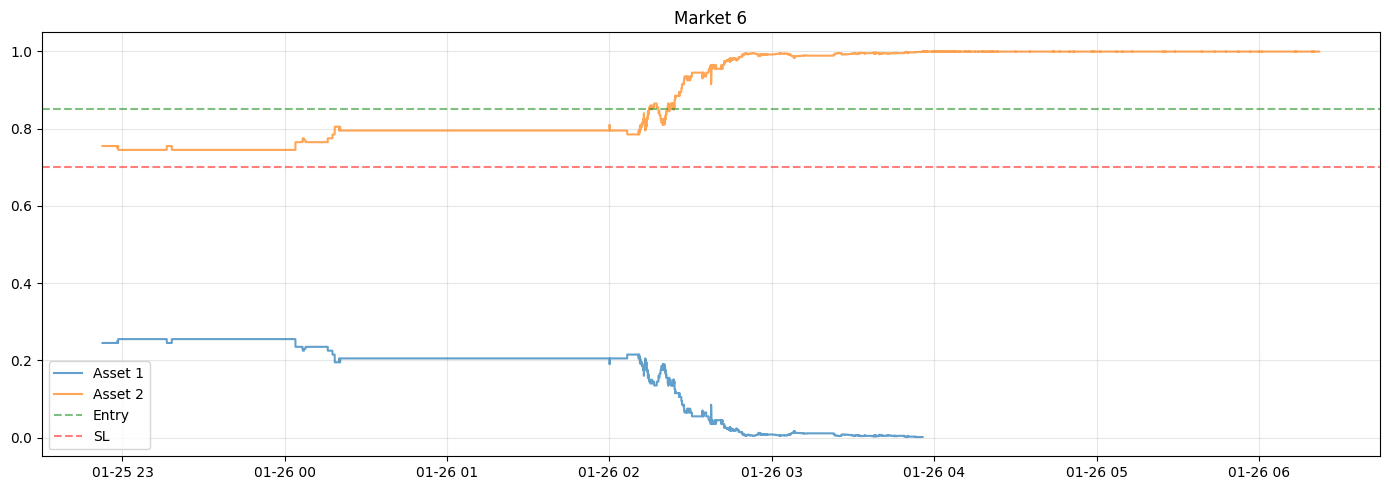

In [17]:
# Plot market
plot_market(df, market_index=5, results=results, params=manual_params)


---
## 5. Debug Export

Decision-by-decision Excel export with orderbook snapshots.


In [ ]:
# ============================================
# DEBUG EXPORT - DECISION BY DECISION WITH ORDERBOOK
# ============================================

def run_backtest_with_debug(df_data, params=None, initial_capital=500, selected_markets=None, 
                            known_winners=None, global_tp_pct=0.07, filename='debug.xlsx', orderbook_levels=3):
    from openpyxl import Workbook
    from openpyxl.styles import Font, PatternFill, Border, Side
    from openpyxl.utils import get_column_letter
    
    default_params = {
        'entry_threshold': 0.68, 'exit_stop_loss': 0.50, 'stop_loss_pct': 0.15, 'take_profit_pct': 0.20,
        'cooldown_periods': 10, 'dca_tier_1': 0.75, 'dca_tier_2': 0.85, 'dca_tier_3': 0.92,
        'weight_entry': 0.15, 'weight_tier_1': 0.20, 'weight_tier_2': 0.30, 'weight_tier_3': 0.35,
    }
    if params is None: params = default_params
    else:
        for k, v in default_params.items():
            if k not in params: params[k] = v

    total_w = sum(params[k] for k in ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3'])
    for k in ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3']:
        params[k] /= total_w

    df = df_data.copy()
    if 'datetime' not in df.columns: df = df.reset_index()
    df = df.sort_values('datetime')

    all_markets = df['market_id'].unique()
    if selected_markets:
        sel_ids = [all_markets[m] if isinstance(m, int) and m < len(all_markets) else m for m in selected_markets]
        df = df[df['market_id'].isin(sel_ids)]
    
    print(f"📊 Processing {df['market_id'].nunique()} markets...")

    # Resample
    if 'raw_json' in df.columns:
        df_idx = df.set_index('datetime')
        def last_valid(x):
            v = x.dropna()
            return v.iloc[-1] if len(v) > 0 else None
        df_res = df_idx.groupby(['asset_id', 'market_id']).resample('5s').agg({
            'mid_price': 'last', 'raw_json': last_valid, 'best_bid': 'last', 'best_ask': 'last'
        }).reset_index().dropna(subset=['mid_price'])
    else:
        df_res = df
    df_res = df_res.sort_values('datetime')

    ENTRY = params['entry_threshold']
    EXIT_SL = params['exit_stop_loss']
    SL_PCT = params['stop_loss_pct']
    TP_PCT = params['take_profit_pct']
    COOLDOWN = params.get('cooldown_periods', 10)
    GLOBAL_TP = initial_capital * global_tp_pct

    DCA_TIERS = [('entry', ENTRY, params['weight_entry']), ('tier_1', params['dca_tier_1'], params['weight_tier_1']),
                 ('tier_2', params['dca_tier_2'], params['weight_tier_2']), ('tier_3', params['dca_tier_3'], params['weight_tier_3'])]

    markets = df_res['market_id'].unique()
    cap_per = initial_capital / len(markets)
    state = {m: {'alloc': cap_per, 'cash': cap_per, 'pos': {}, 'active': None, 'tiers': set(), 'pnl': 0, 'cooldown': {}} for m in markets}
    
    decisions = []
    global_tp = False
    price_cache = {}
    
    print(f"⏳ Running {len(df_res):,} snapshots...")

    for _, row in df_res.iterrows():
        if global_tp: continue
        aid, mid, price, ts, raw = row['asset_id'], row['market_id'], row['mid_price'], row['datetime'], row.get('raw_json')
        if pd.isna(price): continue

        s = state[mid]
        ob = parse_orderbook(raw) if raw else None
        bid = ob.get('best_bid', price) if ob else price
        ask = ob.get('best_ask', price) if ob else price
        
        # Format orderbook
        ob_str = ''
        if ob:
            bids = ' '.join([f"{b['price']:.2f}x{b['size']:.0f}" for b in ob.get('bids', [])[:orderbook_levels]])
            asks = ' '.join([f"{a['price']:.2f}x{a['size']:.0f}" for a in ob.get('asks', [])[:orderbook_levels]])
            ob_str = f"B:[{bids}] A:[{asks}]"

        price_cache[(mid, aid)] = price
        has_pos = aid in s['pos'] and s['pos'][aid].get('shares', 0) > 0

        dec = {'ts': ts, 'market': mid, 'asset': aid, 'mid': price, 'bid': bid, 'ask': ask, 'orderbook': ob_str,
               'action': 'HOLD', 'reason': '', 'details': '', 'has_pos': has_pos,
               'shares': 0, 'avg_entry': 0, 'cash': s['cash'], 'tiers': ','.join(sorted(s['tiers'])),
               'sl_price': None, 'tp_price': None, 'cooldown': False, 'total_pnl': 0}

        if has_pos:
            p = s['pos'][aid]
            dec['shares'] = p['shares']
            dec['avg_entry'] = p['cost'] / p['shares'] if p['shares'] > 0 else 0
            dec['sl_price'] = dec['avg_entry'] * (1 - SL_PCT)
            dec['tp_price'] = dec['avg_entry'] * (1 + TP_PCT)

        # Cooldown check
        if aid in s['cooldown'] and ts < s['cooldown'][aid]:
            dec['cooldown'] = True

        # Total P&L
        total_real = sum(st['pnl'] for st in state.values())
        total_unreal = sum((price_cache.get((m, a), 0) * p.get('shares', 0)) - p.get('cost', 0)
                          for m, st in state.items() for a, p in st['pos'].items() if p.get('shares', 0) > 0)
        dec['total_pnl'] = total_real + total_unreal

        # Global TP
        if dec['total_pnl'] >= GLOBAL_TP:
            dec['action'], dec['reason'] = 'GLOBAL_TP', 'GLOBAL_TAKE_PROFIT'
            dec['details'] = f"${dec['total_pnl']:.2f} >= ${GLOBAL_TP:.2f}"
            global_tp = True
            decisions.append(dec)
            continue

        # Exit logic
        if has_pos:
            p = s['pos'][aid]
            avg = p['cost'] / p['shares'] if p['shares'] > 0 else 0
            
            if bid < EXIT_SL:
                dec['action'], dec['reason'] = 'SELL', 'STOP_LOSS_ABS'
                dec['details'] = f"Bid {bid:.4f} < {EXIT_SL:.2f}"
                proceeds = p['shares'] * bid
                s['pnl'] += proceeds - p['cost']
                s['cash'] += proceeds
                s['pos'][aid] = {'shares': 0, 'cost': 0}
                s['active'], s['tiers'] = None, set()
                s['cooldown'][aid] = ts + pd.Timedelta(seconds=30*COOLDOWN)
                decisions.append(dec)
                continue
            elif avg > 0 and bid < avg * (1 - SL_PCT):
                dec['action'], dec['reason'] = 'SELL', 'STOP_LOSS_PCT'
                dec['details'] = f"Bid {bid:.4f} < {avg*(1-SL_PCT):.4f}"
                proceeds = p['shares'] * bid
                s['pnl'] += proceeds - p['cost']
                s['cash'] += proceeds
                s['pos'][aid] = {'shares': 0, 'cost': 0}
                s['active'], s['tiers'] = None, set()
                s['cooldown'][aid] = ts + pd.Timedelta(seconds=30*COOLDOWN)
                decisions.append(dec)
                continue
            elif avg > 0 and bid >= avg * (1 + TP_PCT):
                dec['action'], dec['reason'] = 'SELL', 'TAKE_PROFIT'
                dec['details'] = f"Bid {bid:.4f} >= {avg*(1+TP_PCT):.4f}"
                proceeds = p['shares'] * bid
                s['pnl'] += proceeds - p['cost']
                s['cash'] += proceeds
                s['pos'][aid] = {'shares': 0, 'cost': 0}
                s['active'], s['tiers'] = None, set()
                s['cooldown'][aid] = ts + pd.Timedelta(seconds=30*COOLDOWN)
                decisions.append(dec)
                continue
            else:
                dec['reason'] = 'HOLDING'
                dec['details'] = f"Bid:{bid:.4f} SL:{dec['sl_price']:.4f} TP:{dec['tp_price']:.4f}"

        # Cooldown
        if aid in s['cooldown']:
            if ts < s['cooldown'][aid]:
                dec['action'], dec['reason'] = 'SKIP', 'COOLDOWN'
                dec['details'] = f"Until {s['cooldown'][aid]}"
                decisions.append(dec)
                continue
            else:
                del s['cooldown'][aid]

        # Entry/DCA
        if price >= ENTRY:
            if s['active'] is None: s['active'] = aid
            if s['active'] == aid:
                for tier, thresh, weight in DCA_TIERS:
                    if tier in s['tiers']: continue
                    if price < thresh: continue
                    amt = min(s['alloc'] * weight, s['cash'])
                    if amt <= 1 or not (ob and ob.get('asks')): continue
                    shares, cost, avg_p, _ = execute_buy_from_orderbook(ob['asks'], amt)
                    if shares > 0:
                        if aid not in s['pos']: s['pos'][aid] = {'shares': 0, 'cost': 0}
                        s['pos'][aid]['shares'] += shares
                        s['pos'][aid]['cost'] += cost
                        s['cash'] -= cost
                        s['tiers'].add(tier)
                        dec['action'], dec['reason'] = 'BUY', tier.upper()
                        dec['details'] = f"{shares:.1f}@${avg_p:.4f}=${cost:.2f}"
                        break
                if dec['action'] == 'HOLD' and not has_pos:
                    dec['action'], dec['reason'] = 'SKIP', 'NO_TIER'
            else:
                dec['action'], dec['reason'] = 'SKIP', 'WRONG_ASSET'
        else:
            if not has_pos:
                dec['action'], dec['reason'] = 'SKIP', 'BELOW_ENTRY'
                dec['details'] = f"{price:.4f} < {ENTRY:.2f}"

        decisions.append(dec)

    print(f"✅ {len(decisions):,} decisions logged")

    # Export
    print(f"📝 Exporting to {filename}...")
    wb = Workbook()
    hfont = Font(bold=True, color='FFFFFF')
    hfill = PatternFill(start_color='4472C4', end_color='4472C4', fill_type='solid')
    buy_fill = PatternFill(start_color='C6EFCE', end_color='C6EFCE', fill_type='solid')
    sell_fill = PatternFill(start_color='FFC7CE', end_color='FFC7CE', fill_type='solid')
    skip_fill = PatternFill(start_color='FFFFCC', end_color='FFFFCC', fill_type='solid')
    border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))

    for mi, mkt in enumerate(markets):
        mdec = [d for d in decisions if d['market'] == mkt]
        if not mdec: continue
        ws = wb.create_sheet(title=f"Market_{mi+1}")
        
        headers = ['Time', 'Asset', 'Mid', 'Bid', 'Ask', 'Orderbook', 'Action', 'Reason', 'Details',
                   'Pos', 'Shares', 'AvgEntry', 'Cash', 'SL', 'TP', 'TotalPnL', 'Tiers', 'CD']
        for c, h in enumerate(headers, 1):
            cell = ws.cell(row=1, column=c, value=h)
            cell.font, cell.fill, cell.border = hfont, hfill, border

        for ri, d in enumerate(mdec[:50000], 2):
            ts_str = d['ts'].strftime('%H:%M:%S') if hasattr(d['ts'], 'strftime') else str(d['ts'])
            vals = [ts_str, str(d['asset'])[-8:], round(d['mid'], 4), round(d['bid'], 4), round(d['ask'], 4),
                    d['orderbook'][:60], d['action'], d['reason'], d['details'][:50],
                    'Y' if d['has_pos'] else '', round(d['shares'], 1) if d['shares'] else '',
                    round(d['avg_entry'], 4) if d['avg_entry'] else '', round(d['cash'], 2),
                    round(d['sl_price'], 4) if d['sl_price'] else '', round(d['tp_price'], 4) if d['tp_price'] else '',
                    round(d['total_pnl'], 2), d['tiers'], 'Y' if d['cooldown'] else '']
            for c, v in enumerate(vals, 1):
                cell = ws.cell(row=ri, column=c, value=v)
                cell.border = border
            fill = {'BUY': buy_fill, 'SELL': sell_fill, 'SKIP': skip_fill}.get(d['action'])
            if fill:
                for c in range(1, len(headers)+1):
                    ws.cell(row=ri, column=c).fill = fill

        widths = [9, 10, 7, 7, 7, 45, 10, 15, 35, 4, 7, 8, 8, 8, 8, 8, 12, 4]
        for c, w in enumerate(widths, 1):
            ws.column_dimensions[get_column_letter(c)].width = w

    if 'Sheet' in wb.sheetnames: del wb['Sheet']
    wb.save(filename)
    print(f"✅ Saved to {filename}")
    return {'decisions': len(decisions)}

print("✅ Debug export loaded")
print("   run_backtest_with_debug(df, selected_markets=[0], filename='debug.xlsx')")


In [ ]:
# Run debug export on single market
run_backtest_with_debug(
    df,
    params=manual_params,
    initial_capital=INITIAL_CAPITAL,
    global_tp_pct=GLOBAL_TP_PCT,
    known_winners=known_winners_25jan,
    selected_markets=[0],  # <- CHANGE
    filename='debug_market_1.xlsx',
    orderbook_levels=3,
)


---
## 6. Optuna Multi-Day Optimization

Optimize parameters across multiple days simultaneously.


In [ ]:
# ============================================
# OPTUNA MULTI-DAY OPTIMIZATION
# ============================================

def run_optuna_multiday(datasets, n_trials=100, initial_capital=500, global_tp_pct=0.07):
    """
    Optimize across multiple days.
    
    datasets: List of (df, known_winners, name) tuples
    Example: [(df_24jan, known_winners_24jan, '24jan'), (df_25jan, known_winners_25jan, '25jan')]
    """
    # Prepare datasets
    prepared = []
    for df_data, known_winners, name in datasets:
        df = df_data.copy()
        if 'datetime' not in df.columns: df = df.reset_index()
        df = df.sort_values('datetime')
        
        if 'raw_json' in df.columns:
            df_idx = df.set_index('datetime')
            def last_valid(x):
                v = x.dropna()
                return v.iloc[-1] if len(v) > 0 else None
            df_res = df_idx.groupby(['asset_id', 'market_id']).resample('5s').agg({
                'mid_price': 'last', 'raw_json': last_valid
            }).reset_index().dropna(subset=['mid_price'])
        else:
            df_res = df
        df_res = df_res.sort_values(['asset_id', 'datetime'])
        
        # Build market winners
        mkt_winners = {}
        for mkt in df_res['market_id'].unique():
            mdf = df_res[df_res['market_id'] == mkt]
            last_ts = mdf['datetime'].max()
            last_p = mdf[mdf['datetime'] == last_ts][['asset_id', 'mid_price']].dropna().copy()
            if len(last_p) == 0: continue
            if known_winners and mkt in known_winners:
                mkt_winners[mkt] = {'winner_asset': known_winners[mkt], 'winner_price': 1.0, 'loser_price': 0.0, 'last_ts': last_ts}
            else:
                last_p['d'] = abs(1.0 - last_p['mid_price'])
                wi = last_p['d'].idxmin()
                mkt_winners[mkt] = {'winner_asset': last_p.loc[wi, 'asset_id'], 
                                   'winner_price': last_p.loc[wi, 'mid_price'],
                                   'loser_price': 0, 'last_ts': last_ts}
        
        prepared.append((df_res, mkt_winners, name))
        print(f"✅ {name}: {len(df_res):,} rows, {len(mkt_winners)} markets")
    
    def objective(trial):
        params = {
            'entry_threshold': trial.suggest_float('entry_threshold', 0.60, 0.75),
            'exit_stop_loss': trial.suggest_float('exit_stop_loss', 0.40, 0.55),
            'stop_loss_pct': trial.suggest_float('stop_loss_pct', 0.08, 0.20),
            'take_profit_pct': trial.suggest_float('take_profit_pct', 0.12, 0.30),
            'cooldown_periods': trial.suggest_int('cooldown_periods', 5, 20),
            'dca_tier_1': trial.suggest_float('dca_tier_1', 0.70, 0.80),
            'dca_tier_2': trial.suggest_float('dca_tier_2', 0.80, 0.90),
            'dca_tier_3': trial.suggest_float('dca_tier_3', 0.88, 0.95),
            'weight_entry': trial.suggest_float('weight_entry', 0.10, 0.25),
            'weight_tier_1': trial.suggest_float('weight_tier_1', 0.15, 0.30),
            'weight_tier_2': trial.suggest_float('weight_tier_2', 0.20, 0.35),
            'weight_tier_3': trial.suggest_float('weight_tier_3', 0.25, 0.40),
        }
        
        # Normalize weights
        tw = sum(params[k] for k in ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3'])
        for k in ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3']:
            params[k] /= tw
        
        # Ensure tier ordering
        if not (params['entry_threshold'] < params['dca_tier_1'] < params['dca_tier_2'] < params['dca_tier_3']):
            return -1.0
        
        total_return = 0
        for df_res, mkt_winners, name in prepared:
            try:
                res = run_backtest_v6(params, df_res, mkt_winners, initial_capital, global_tp_pct)
                total_return += res['total_return']
            except:
                return -1.0
        
        return total_return / len(prepared)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print("\n" + "="*50)
    print("🏆 OPTUNA RESULTS")
    print("="*50)
    print(f"Best Avg Return: {study.best_value*100:.2f}%")
    print("\nBest Parameters:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
    
    # Per-day results
    bp = study.best_params.copy()
    tw = sum(bp[k] for k in ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3'])
    for k in ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3']:
        bp[k] /= tw
    
    print("\n📊 Per-Day Results:")
    for df_res, mkt_winners, name in prepared:
        res = run_backtest_v6(bp, df_res, mkt_winners, initial_capital, global_tp_pct)
        print(f"  {name}: ${res['total_pnl']:+.2f} ({res['total_return']*100:+.1f}%)")
    
    return study, study.best_params

print("✅ Optuna multi-day loaded")
print("   study, best = run_optuna_multiday([")
print("       (df_24jan, known_winners_24jan, '24jan'),")
print("       (df_25jan, known_winners_25jan, '25jan'),")
print("   ], n_trials=100)")


In [ ]:
# ============================================
# RUN OPTUNA ON MULTIPLE DAYS
# ============================================
# Uncomment and run after loading multiple days

# study, best_params = run_optuna_multiday([
#     (df_24jan, known_winners_24jan, '24jan'),
#     (df_25jan, known_winners_25jan, '25jan'),
#     (df_26jan, known_winners_26jan, '26jan'),
# ], n_trials=100)


In [ ]:
# Run Optuna on single day
# study, best_params = run_optuna_multiday([
#     (df, known_winners_25jan, '25jan'),
# ], n_trials=50)
